# 타이타닉 데이터셋 구축하기

- 내가(pythonash) 만든 tidy dataset으로, 타이타닉 생존자예측 top 5%를 달성하게 해준 데이터셋으로 진행한다.

- 코드를 실행함에 있어 모든 데이터셋의 기준이 될 예정이다. `필요시 추가`



In [52]:
#==========필요한 모듈 다운로드==========#
!pip install pdpbox
!pip install lime
import pandas as pd
import numpy as np
import tensorflow as tf
from pdpbox import info_plots, pdp
from sklearn.datasets import fetch_olivetti_faces
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import cv2
from skimage.color import label2rgb
import matplotlib.pyplot as plt
#==========필요한 데이터셋 구축==========#
def build_setting():
  train_x = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/train_x.csv')
  val_x = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/val_x.csv')
  train_y = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/train_y.csv')
  val_y = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/val_y.csv')
  test_x = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/test_x.csv')
  
  df_x = pd.concat([train_x, val_x],axis=0)
  df_y = pd.concat([train_y, val_y],axis=0)
  df = pd.concat([df_x, df_y], axis=1)
  #==========간단한 딥러닝 모델 구축==========#  
  deep_model = tf.keras.models.Sequential([
                                      tf.keras.layers.Input(shape = [len(df_x.columns)]),
                                      tf.keras.layers.Dense(16, activation = 'relu'),
                                      tf.keras.layers.Dense(16, activation = 'relu'),
                                      tf.keras.layers.Dense(16, activation = 'relu'),
                                      tf.keras.layers.Dense(16, activation = 'relu'),
                                      tf.keras.layers.Dense(1, activation = 'sigmoid')])
  deep_model.compile(loss = 'binary_crossentropy', metrics=['accuracy'], optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001))
  deep_model.fit(train_x, train_y, epochs =10, validation_data = (val_x, val_y))

  #==========간단한 이미지 딥러닝 모델 구축 및 이미지 데이터 로드==========#
  (img_x, img_y), (img_x_test, img_y_test) = tf.keras.datasets.cifar10.load_data()
  img_x = img_x/255
  img_y = tf.keras.utils.to_categorical(img_y)
  img_x_test = img_x_test/255
  img_y_test = tf.keras.utils.to_categorical(img_y_test)
  image_model = tf.keras.models.Sequential([
                                            tf.keras.layers.Input(shape = img_x.shape[1:]),
                                            tf.keras.layers.Conv2D(8, 2, 1, padding='same', activation='relu'),
                                            tf.keras.layers.Conv2D(8, 2, 1, padding='same', activation='relu'),
                                            tf.keras.layers.Conv2D(8, 2, 1, padding='same', activation='relu'),
                                            tf.keras.layers.Conv2D(8, 2, 1, padding='same', activation='relu'),
                                            tf.keras.layers.Dropout(0.2),
                                            tf.keras.layers.Flatten(),
                                            tf.keras.layers.Dense(16, activation = 'relu'),
                                            tf.keras.layers.Dense(16, activation = 'relu'),
                                            tf.keras.layers.Dense(16, activation = 'relu'),
                                            tf.keras.layers.Dense(10, activation = 'softmax')
  ])
  image_model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'], optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001))
  image_model.fit(img_x, img_y, epochs = 10, validation_split = 0.3)
  return df, df_x, df_y, test_x, deep_model, img_x, img_y, img_x_test, img_y_test, image_model

df, train_x, train_y, test_x, model, img_x, img_y, img_x_test, img_y_test, image_model = build_setting()

image_model.evaluate(img_x_test, img_y_test)

Epoch 1/10
23/23 [==============================] - 1s 15ms/step - loss: 0.6859 - accuracy: 0.6025 - val_loss: 0.6715 - val_accuracy: 0.6425
Epoch 2/10
23/23 [==============================] - 0s 6ms/step - loss: 0.6448 - accuracy: 0.7065 - val_loss: 0.6320 - val_accuracy: 0.7318
Epoch 3/10
23/23 [==============================] - 0s 6ms/step - loss: 0.5953 - accuracy: 0.7626 - val_loss: 0.5772 - val_accuracy: 0.7374
Epoch 4/10
23/23 [==============================] - 0s 6ms/step - loss: 0.5350 - accuracy: 0.7837 - val_loss: 0.5146 - val_accuracy: 0.7709
Epoch 5/10
23/23 [==============================] - 0s 6ms/step - loss: 0.4777 - accuracy: 0.8006 - val_loss: 0.4733 - val_accuracy: 0.7654
Epoch 6/10
23/23 [==============================] - 0s 6ms/step - loss: 0.4477 - accuracy: 0.8034 - val_loss: 0.4608 - val_accuracy: 0.7933
Epoch 7/10
23/23 [==============================] - 0s 6ms/step - loss: 0.4430 - accuracy: 0.8216 - val_loss: 0.4543 - val_accuracy: 0.7933
Epoch 8/10
23/23 [=

[1.3523569107055664, 0.5252000093460083]

# 부분 의존성 플랏

- 피처의 `수치 변화에 따라 모델에 기여하는 정도`가 어떻게 달라지는지 확인 할 수 있는 XAI기법.

- 궁금한 피처가 `긍정/부정의 영향`을 미치는지 파악하게 해준다.

- 특정 피처에 대해 `버퍼존을 표시`해줌으로써 피쳐간 `독립성이 성립되지 않는 환경`에서 어느 정도 `모델에 오차`가 있을 수 있는지 확인하게 해준다.

- 피처 간 `종속관계가 있을 때에도 활용이 가능` 하다.

## info_plots.target_plot()

- 일단 이 모델은 `학습된 모델을 파라미터로 받지 않는다.`

- 이는 학습데이터를 분석해서 `모델이 어떻게 학습할 것인지 예상하는 XAI 기법`이다.

- 만약 `특정 피쳐의 데이터 구조가 편향`(남자 98%, 여자 2% 분포 등) 되어 있다면, 그 `데이터에 맞춰 결론이 왜곡`돼 있을 수 있다.

그렇다면, 모델을 뜯어보지 않아도 `어떤 편향으로 모델이 학습될지 파악가능`하다.

`구간 별 결과의 비율을 표시`해준다.

> 가령 예를 들어, Fare가 0.14 ~ 1일 때 72.5%의 값을 갖는데, 이는 실제 데이터에서 Fare가 0.14보다 높은 집단의 생존(1) 데이터 개수를  전체 경우(1과 0)의 데이터 개수로 나눈 값 즉, 74 / (74 + 28) = 0.725가 되는 것 이다. 

그리고 이러한 알고리즘을 구현해 놓은 것이 pdpbox 패키지 이다.

In [ ]:
print(df[df['Fare'] >= 0.14]['Survived'].value_counts())
print(74/(74+28))

1    74
0    28
Name: Survived, dtype: int64
0.7254901960784313


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


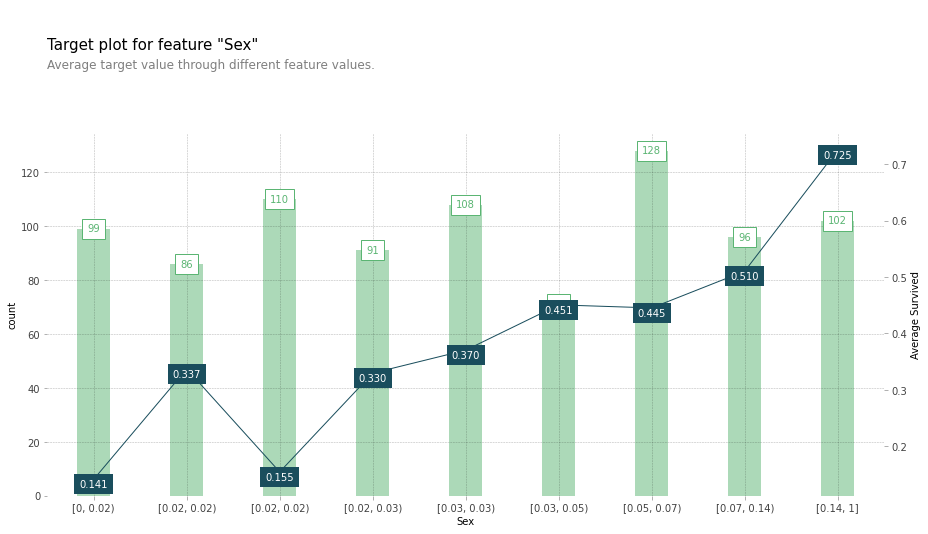

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df = df, # 피쳐 + 타겟 데이터
    feature = 'Fare', # 피쳐
    feature_name = 'Fare', # 표시할 이름
    target = 'Survived' # 타겟
)

`X 축은 피쳐`에 대한 정보, `왼쪽 Y축`은 각 수치 혹은 구간별 `데이터 수`, `오른쪽 Y축`은 `타겟(생존여부)에 대한 확률, 혹은 비율 값`이다.

`막대 그래프는 왼쪽 Y축`, `꺾은선 그래프는 오른쪽 Y축`에 대응한다.


이 그래프를 예로 들면, **Fare**의 경우(지금은 정규화 되어 0과 1사이의 값을 가짐) `0과 0.02` 사이에 속한 그룹은 데이터 개수는 99개, 이때 생존확률의 분포는 `14.1%`가 된다.

반대로, `0.14 ~ 1`사이에 속한 그룹의 경우 데이터 개수는 102개로 이때 생존 확률의 분포는 `72.5%`에 육박한다.



## 부분 의존성 플랏 결과 저장

- 결과를 DataFrame 포맷으로 저장한다.

In [ ]:
summary_df

,x,display_column,value_lower,value_upper,count,Survived
0,0,"[0, 0.02)",0.000000,0.015094,99,0.141414
1,1,"[0.02, 0.02)",0.015094,0.015412,86,0.337209
2,2,"[0.02, 0.02)",0.015412,0.016908,110,0.154545
3,3,"[0.02, 0.03)",0.016908,0.025374,91,0.329670
4,4,"[0.03, 0.03)",0.025374,0.032596,108,0.370370
5,5,"[0.03, 0.05)",0.032596,0.050749,71,0.450704
6,6,"[0.05, 0.07)",0.050749,0.068532,128,0.445312
7,7,"[0.07, 0.14)",0.068532,0.143462,96,0.510417
8,8,"[0.14, 1]",0.143462,1.000000,102,0.725490


# 예측 분포 플랏(prediction distribution plot)

- 데이터와 실제 모델을 결합해 두 결과가 일치하는지 확인 하는 방법

- 훈련된 모델을 집어넣었냐 아니냐에 따라 결과가 다르다.

- 상자안의 값은 구간별 예측값의 중앙값에 해당한다.

In [ ]:
##############Fare가 0.14와 1 사이의 값일 때 박스안에 표시될 예측 중앙값#################
dd = train_x.copy()
dd['predict'] = model.predict(train_x)
result = dd[dd['Fare'] >= 0.14]['predict'].median()
result

0.8062437772750854

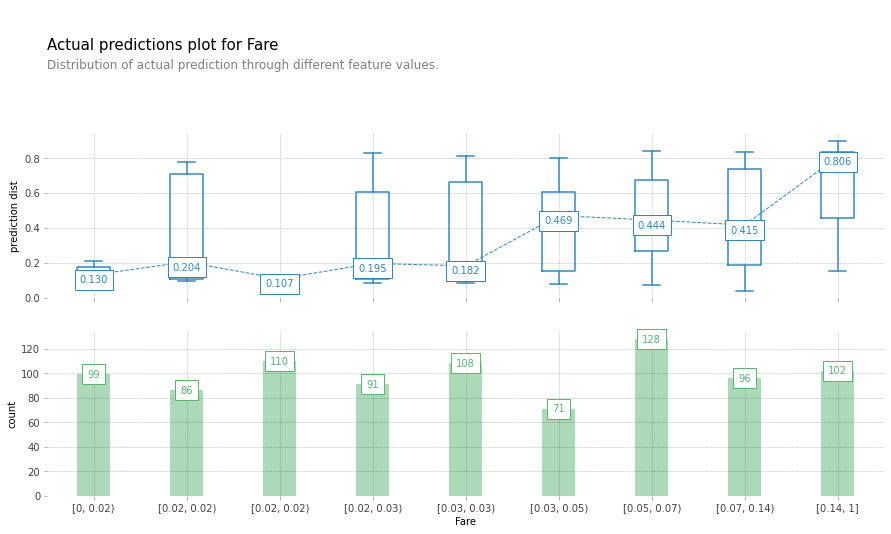

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
    model = model, # 훈련된 모델 입력, 훈련된 모델입력하지 않으면 결과가 좀 달라지더라
    X = train_x, # 입력변수
    feature = 'Fare', # 보고자 하는 피쳐
    feature_name = 'Fare', # 피쳐 이름
    predict_kwds = {}
)

## 해석

위의 캔들스틱 차트는 `X의 구간별 예측 분포`를 나타낸다.

- 모델이 구간별로 예측한 값을 내놓고 있으며, 박스 안의 값(예를 들어, 첫 번째 캔들스틱의 0.130)은 중앙값의 예측 확률이 된다.

- 구간에 따라 편차가 큰 것도 존재한다.

아래의 막대 그래프는 `x의 구간에 따른 데이터 개수 그래프`를 나타낸다.

> 이것으로 알 수 있는 것은, Fare의 경우 타이타닉 생존자의 확률을 예측하는데에 꽤 유의한 변수로 작용할 수 있다는 점이다.

- 왜냐하면, Fare의 값이 커짐에 따라 다소 우상향 하는 추이를 보이고 예를 들어, Fare 값이 `0.14 ~ 1`사이라면, 꽤 높은 확률로 생존했을 것임을 모델은 추측하고 있다.

그리고 이는 앞의 `info_plots.target_plot()`과도 비슷한 양상을 보여주고 있다.

Fare 구간 `[0, 0.02]`를 예로 들자면,

- `info_plots.target_plot()` 에서는 `평균 예측 확률이 14.1%`로 예상된다.

- `info_plots.actual_plot()` 에서는 `평균 예측 확률이 13%` 였다.



# 부분 의존성 수치 계산 및 그래프 그리기

`pdp.pdp_isolate()` 은 피처 하나에 대한 부분 의존성 수치를 계산한다.

- 이때 반한되는 값인 pdp_gc에는 피쳐에 대한 부분 의존성 계산 값이 담긴 객체(PDPIsolate)가 저장된다.

`pdp.pdp_plot()`은 pdp_gc에 담긴 부분 의존성 계산 값을 플롯팅 해주는 것이다.

- plot_lines = True면 부분 의존성 알고리즘 매회에 대응하는 별도의 라인이 표시된다.

- plot_pts_dist = True 면, X축 밑에 데이터가 얼마나 분포하는지를 세로 막대로 표시해준다.

> 따라서, 데이터가 얼마나 밀집돼 있는지 시각적으로 확인할 수 있다.

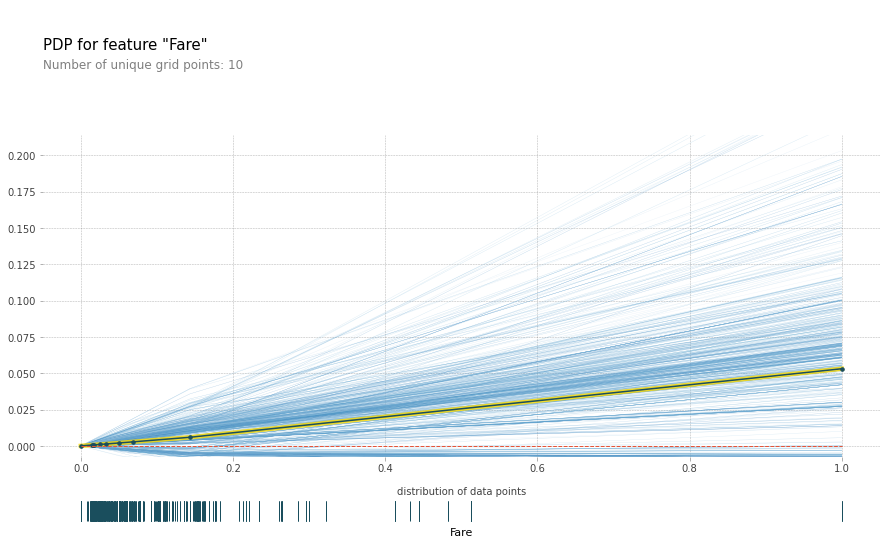

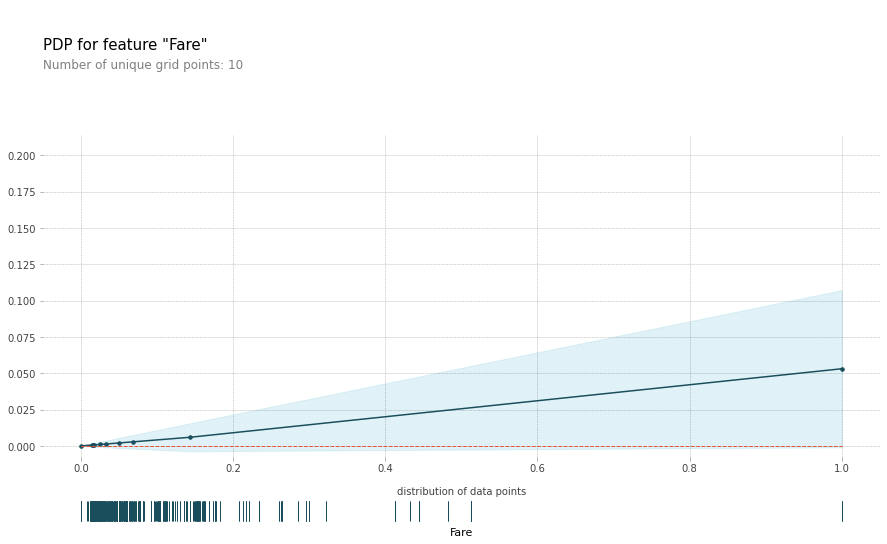

In [ ]:
pdp_gc = pdp.pdp_isolate(
    model = model, # 모델
    dataset = df, # 전체 데이터셋 
    model_features = train_x.columns, # 컬럼 리스트 입력
    feature = 'Fare' # 보고자 하는 피쳐 입력
)
fig, axes = pdp.pdp_plot(
    pdp_gc,
    'Fare',
    plot_lines = True,
    frac_to_plot = 1,
    plot_pts_dist = True
)

fig, axes = pdp.pdp_plot(
    pdp_gc,
    'Fare',
    plot_lines = False,
    frac_to_plot = 1,
    plot_pts_dist = True
)

여기서 `Number of unique grid points`란 데이터 포인트를 몇개로 자르는 지(구간을 나누는 포인트)에 대한 것으로 이 예제에서는 `10이니까 0.1단위로 grid point`가 잡힌 것 이다.

이 그래프에서는 단순히 x축의 값에 따라 어떻다~ 보다는 +, -를 확인하면서 어느 방향으로 움직이는 지 정도만 파악해 보자. 위에서 그린 `info_plot_target_plots()` 나 `info_plot_actual_plots()`와는 다르다.

다른 이유는 내 생각에 위에 것은 전체 피쳐를 고려하는데, 이것은 단일의 피쳐만 고려하기 때문이 아닐까.

# 두가지 피처에 대한 부분 의존성 플랏 시각화

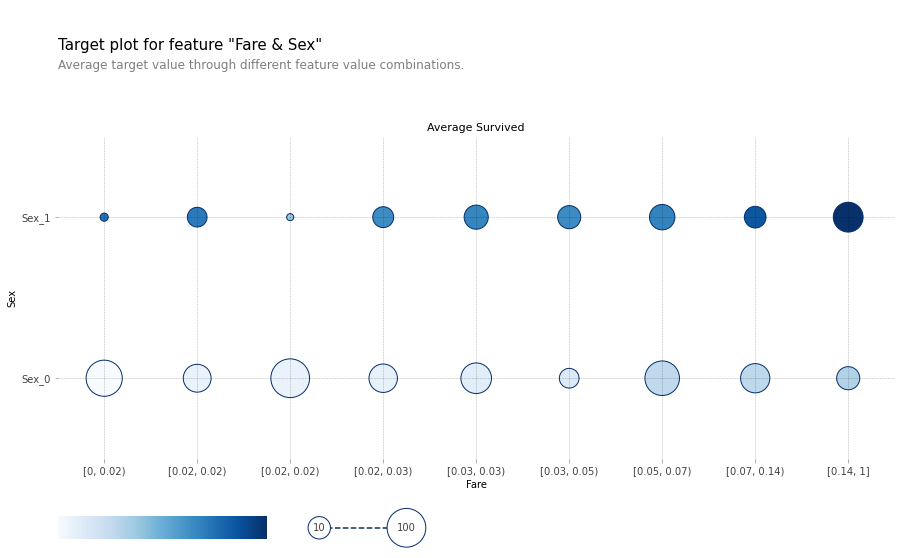

In [ ]:
fig, axes, summary_df = info_plots.target_plot_interact(
                                                         df = df,
                                                         features = ['Fare','Sex'],
                                                         feature_names = ['Fare', 'Sex'],
                                                         target = 'Survived'
)

여기서 `원의 크기는 학습 데이터`를 의미한다. 즉, 원이 적거나 클 수록 사례가 적거나 많다.

`생존 확률`에 대한 것은 `원의 색`으로 구분이 가능한데, 원 안의 색이 `진할 수록` 생존확률이 `높아진다`.

따라서, `성별이 1(여자)이고 Fare가 높을 수록` 생존확률이 높은 걸 알 수 있고, `성별`로 `생존확률이 극명히 차이`가 나는 것을 알 수 있다.

# 두 가지 피처에 대한 모델의 부분 의존성 플랏

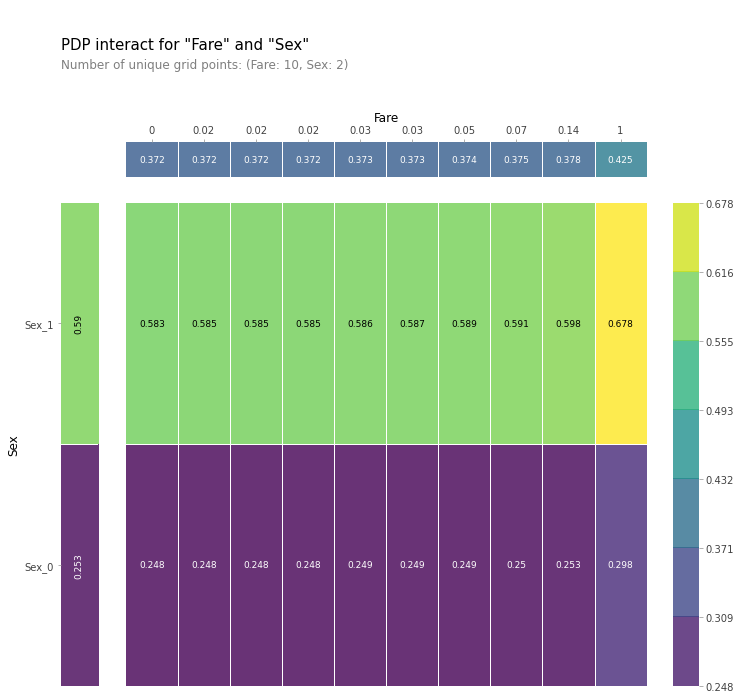

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = model,
    dataset = df,
    model_features = train_x.columns,
    features = ['Fare', 'Sex']
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names =['Fare','Sex'],
    plot_type ='grid',
    x_quantile = True,
    plot_pdp=True
)

이 결과는 위의 isolate과 비슷하게, `Fare의 경우(맨위 박스들)에는 색의 변화가 미미` 하다.

하지만, `성별의 경우에는 극명한 차이`를 보여주고 있다.

또한, `성별이 1(여자)이고, Fare가 높을 때의 생존 확률은 0.678정도로 추론`되고 있는데, 이는 이 모델이

`성별이 여자`이고 `Fare가 높았을 경우` 생존했을 `확률을 높게` 보고 있다는 것이다.

# 대리 분석 기법(Surrogate Analysis)

- 본래 기능을 흉내 내는 간단한 대체재를 만들어서 프로토타입이 동작하는지 판단하는 분석 방법.

- XAI에서는 대리 분석은 본래 `인공지능 모델이 너무 복잡해서` 분석이 불가능할 때 `유사한 기능을 흉내` 내는 인공지능 모델 여러 개를 `대리로` 만들어서 본래 모델을 분석하는 기법.

> 분석할 모델을 f, 대리 모델을 g라고 하면

- 둘의 분석 기법(부스팅, 회귀, 딥러닝 등)은 다를 수 있다. 하지만, 모델 g는 설명 가능해야 하며, f와 유사한 만큼의 성능을 내야 한다.

## 로컬 대리 분석(Local Surrogate Analysis)

- 모델이 학습 데이터 하나를 해석하는 과정

- LIME (Local Interpretable Model-agnostic Explanations)으로 더 잘 알려져 있다.

- Model-agnostic (모델에 대한 깊은 지식 없이도 학습할 수 있음)

# 이미지 LIME

분할 알고리즘에 따라 XAI 성능이 크게 달라진다.

따라서, 직접 이미지 분할 알고리즘을 지정해서 LIME의 설명 능력을 높여볼 수 있다.

> 실제로 해보니까 R, G, B 채널을 가진 이미지에서만 작동한다.

`SegmentationAlgorithm에 들어가는 파라미터`

- quickshift (default)

- slic

- felzenszwalb

In [53]:
explainer = lime_image.LimeImageExplainer()

seg = SegmentationAlgorithm('slic',
                            n_segments=100, # 이미지 분할 조각 개수
                            compactness=1, # 분할한 이미지 조각으로부터 유사한 파트를 합치는 함수.
                                           # 숫자는 로그스케일이고, 숫자가 클수록 합쳐지는 비율이 높다.
                                           # 일반적으로 0.01, 0.1, 1, 10, 100을 권장한다.
                            sigma = 1)     # 분할한 이미지를 부드럽게 깎아주는 정도(스무딩).
                                           # 0은 스무딩 없음, 1은 스무딩 최대

In [56]:
%%time
# 실행시간 표시해줌
exp = explainer.explain_instance(img_x_test[0], # 샘플이미지 입력
                                 classifier_fn = image_model, # 설명 모델 입력
                                 top_labels =6, # 모델이 예측한 1등부터 6등까지의 분류 값을 분석
                                 num_samples=1000, # 결정 경계를 결정하기 위해 샘플링하는 공간
                                 segmentation_fn = seg)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1.48 s, sys: 256 ms, total: 1.74 s
Wall time: 1.64 s


## 설명 대상 이미지 출력하기

KeyError: ignored

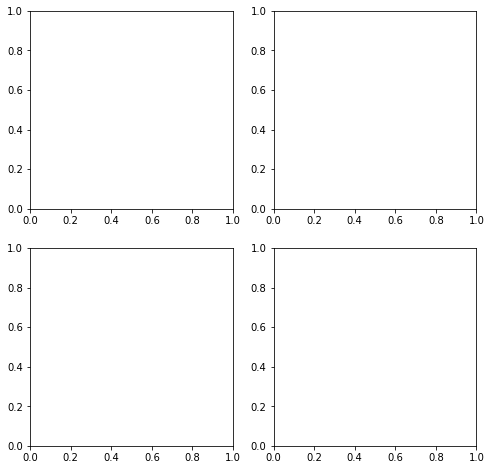

In [84]:
%%time
#===== 플랏팅하는거 참고용으로 알아두기 =====#
#=================================================================================#

#===== 서브 플랏 설정 =====#
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (8,8))

#===== 예측에 도움이 되는 부분만 사진에서 보여주게끔 출력하기 =====#
temp, mask = exp.get_image_and_mask(4,
                                    positive_only = True,
                                    num_features =8, 
                                    hide_rest=False)
ax1.imshow(label2rgb(mask, temp, bg_label = 0),
           interpolation = 'nearest')
ax1.set_title('Title of fig. 1 of axis 1.')


#===== 모든 부분 출력하기 =====#
temp, mask = exp.get_image_and_mask(4,
                                    positive_only = False,
                                    num_features=8,
                                    hide_rest = False)
ax2.imshow(label2rgb(4 - mask, temp, bg_label=0),
           interpolation='nearest')
ax2.set_title('Title of fig. 2 of axis 1.')

#===== 이미지만 출력 =====#
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Title of fig. 3 of axis 2.')

#===== 마스크만 출력 =====#
ax4.imshow(mask, interpolation='nearest')
ax4.set_title('Title of fig. 4 of axis 2.')

In [85]:
exp.top_labels

[8, 3, 0, 5, 9, 7]